<a href="https://colab.research.google.com/github/nisargdoshi9/siamese_network_few_shot_learning/blob/main/Siamese_NW_Fruits360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install opendatasets

In [ ]:
# !pip install pandas

In [ ]:
# #Configuration environment
# import os

# os.environ['KAGGLE_USERNAME'] = "nisargx9" # username from the json file
# os.environ['KAGGLE_KEY'] = "xxxremovedxxx" # key from the json file

In [ ]:
# cd '/content/drive/MyDrive/Projects/Fruit360'

In [ ]:
# !kaggle datasets download -d moltean/fruits

In [ ]:
# !unzip "/content/drive/MyDrive/Projects/Fruit360/fruits.zip" -d "/content/drive/MyDrive/Projects/Fruit360/fruits"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2

import tensorflow as tf
import keras


In [ ]:
dir = "/content/drive/MyDrive/Projects/Fruit360/fruits/fruits-360_dataset/fruits-360/Training"
split = 0.7
num_files_each_class = 10

folder_list = os.listdir(dir)
print(len(folder_list),": number of categories")

131 : number of categories


## Loading dataset into numpy arrays

In [ ]:
x = []
y = []
cat_list = []
y_label = 0
for folder_name in folder_list:
  file_list = os.listdir(dir+'/'+folder_name)
  temp = []
  for file_name in file_list[:num_files_each_class]:
    temp.append(len(x))
    im = cv2.imread(dir+'/'+folder_name+'/'+file_name)
    im = cv2.resize(im,(100,100))
    x.append(im)
    y.append(y_label)
  y_label+=1
  cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255
y = np.asarray(y)
print('X,y, cat_list shape: ',x.shape,y.shape,cat_list.shape)

X,y, cat_list shape:  (1310, 100, 100, 3) (1310,) (131, 10)


# Train test split: Unlike usual training, only training on 70% classes/categories and keep the rest for test

In [ ]:
num_classes = int(len(folder_list)*split)
print('Number of folders to train (approx): ',int(num_classes))
num_files = int(x.shape[0]*split)
print('Number of files to train: ',int(num_files))

#Split
x_train = x[:num_files]
y_train = y[:num_files]
cat_train = cat_list[:num_classes]

x_val = x[num_files:]
y_val = y[num_files:]
cat_test = cat_list[num_classes:]

print("Shape of x_train, y_train, cat_train: ",x_train.shape,y_train.shape,cat_train.shape)
print("Shape of x_val, y_val, cat_test: ",x_val.shape,y_val.shape,cat_test.shape)

Number of folders to train (approx):  91
Number of files to train:  916
Shape of x_train, y_train, cat_train:  (916, 100, 100, 3) (916,) (91, 10)
Shape of x_val, y_val, cat_test:  (394, 100, 100, 3) (394,) (40, 10)


## Batch generation function

In [ ]:
def get_batch(batch_size=64):
  temp_x = x_train
  temp_cat_list = cat_train
  start = 0
  end = num_classes
  batch_x = []

  batch_y = np.zeros(batch_size)
  # Setting other half to 0
  batch_y[int(batch_size/2):]=1
  np.random.shuffle(batch_y)

  class_list = np.random.randint(start,end,batch_size)
  batch_x.append(np.zeros((batch_size,100,100,3)))
  batch_x.append(np.zeros((batch_size,100,100,3)))

  for i in range(batch_size):
    batch_x[0][i]=temp_x[np.random.choice(temp_cat_list[class_list[i]])]
    # if y_train=0 pick same class, else if y_train=1 pick any other class
    if batch_y[i]==0:
      batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
    else:
      temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
      batch_x[1][i] = temp_x[np.random.choice(temp_list)]
  return (batch_x, batch_y)

## Sequential Model

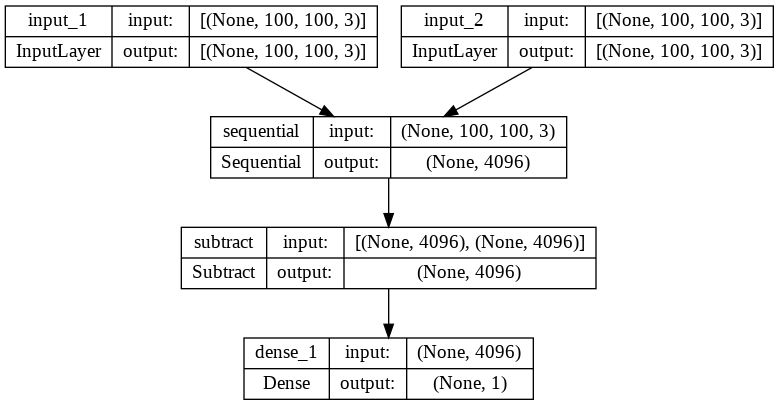

In [ ]:
from keras.layers import Input, Conv2D, Lambda, Concatenate, Dense, Flatten, MaxPooling2D, Subtract
from keras.models import Model,Sequential
from keras.losses import binary_crossentropy
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.utils import plot_model

W_init = keras.initializers.RandomNormal(mean=0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean=0.0, stddev = 1e-2)

input_shape = (100,100,3)
left_input = Input(input_shape)
right_input = Input(input_shape)

model = Sequential([
  keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

subtracted = Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model([left_input, right_input], prediction)

optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)


In [ ]:
def nway_one_shot(model, n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(num_classes+1, len(folder_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

In [ ]:
epochs = 30000
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size)
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%250 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break

Streaming output truncated to the last 5000 lines.
Epoch: 25557 , Loss: 0.0004960311343893409
Epoch: 25558 , Loss: 0.0005005330895073712
Epoch: 25559 , Loss: 0.0004954634932801127
Epoch: 25560 , Loss: 0.0004958545323461294
Epoch: 25561 , Loss: 0.0004919614875689149
Epoch: 25562 , Loss: 0.0004957318305969238
Epoch: 25563 , Loss: 0.0005007173167541623
Epoch: 25564 , Loss: 0.0004964363179169595
Epoch: 25565 , Loss: 0.0004948038258589804
Epoch: 25566 , Loss: 0.0004963933024555445
Epoch: 25567 , Loss: 0.0004962299717590213
Epoch: 25568 , Loss: 0.000500899797771126
Epoch: 25569 , Loss: 0.0004953332245349884
Epoch: 25570 , Loss: 0.0004930633585900068
Epoch: 25571 , Loss: 0.00049511285033077
Epoch: 25572 , Loss: 0.0004929535207338631
Epoch: 25573 , Loss: 0.000494724081363529
Epoch: 25574 , Loss: 0.0004951164009980857
Epoch: 25575 , Loss: 0.0004941792576573789
Epoch: 25576 , Loss: 0.0004991415189579129
Epoch: 25577 , Loss: 0.0004986018757335842
Epoch: 25578 , Loss: 0.0004888872499577701
Epoch: 